# CHEOPS Data Reduction pipeline: Telescopes and Detectors for Space Sciences - Practical Work

**Student name:** Telmo Monteiro
**Student number:** up202308183

This is the pipeline made for the practical work of the course "Telescopes and Detectors for Space Sciences".

There are three main modules:

- Calibration: bias, dark and flat-field corrections
- Correction: depointing
- Photometry: aperture photometry

The final step was the light curve plotting and an estimation of the radius of KELT11-b.

## Useful modules and functions

In [1]:
import os, glob, numpy as np, pandas as pd, scipy as sp, matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.colors as colors
from matplotlib.patches import Circle
import tqdm, time

import astropy
from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.visualization import simple_norm, ZScaleInterval
from astropy.modeling.functional_models import Gaussian2D

import photutils
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, ApertureStats, CircularAperture, CircularAnnulus

from scipy.ndimage import label, center_of_mass
from scipy import stats
from scipy.optimize import curve_fit
from skimage import filters

import emcee, corner

To plot an image:

In [2]:
def plot_img(data,norm_mode):
    fig, ax = plt.subplots(1)
    if norm_mode == "log":
        norm = colors.LogNorm()
    elif norm_mode == "simple":
        zscale = ZScaleInterval()
        zlims = zscale.get_limits(data)
        norm = simple_norm(data, min_cut=zlims[0], max_cut=zlims[1])
    elif norm_mode == "none":
        norm = None
    im = ax.imshow(data, origin='lower', norm=norm, cmap=plt.get_cmap("gray"))
    plt.colorbar(im);
    return fig,ax

To obtain the statistic of an image: standard deviation, mean and median.

In [3]:
def plot_flux_statistic_by_img(statistic,data):
    if statistic == "Mean":
        stat_array = [np.mean(data[x]) for x in range(0,data.shape[0])]    
    elif statistic == "Median":
        stat_array = [np.median(data[x]) for x in range(0,data.shape[0])]    
    elif statistic == "Standard deviation":
        stat_array = [np.std(data[x]) for x in range(0,data.shape[0])]    
    return stat_array

# Data

In [4]:
target = "KELT-11"

folder_path = f"{target}"

path2files = {}
for filetype in ["FullArray", "Imagette", "SubArray"]:
    res = glob.glob(os.path.join(folder_path, f"*{filetype}*"))
    if len(res) == 0:
        raise ValueError(f"File {filetype} not found !")
    else:
        path2files[filetype] = res[0]
        
print(path2files)

{'FullArray': 'KELT-11\\CH_PR300024_TG000101_TU2020-03-09T14-49-43_SCI_RAW_FullArray_V0101.fits', 'Imagette': 'KELT-11\\CH_PR300024_TG000101_TU2020-03-09T14-50-33_SCI_RAW_Imagette_V0101.fits', 'SubArray': 'KELT-11\\CH_PR300024_TG000101_TU2020-03-09T14-50-41_SCI_RAW_SubArray_V0101.fits'}


In [5]:
with fits.open(path2files["SubArray"]) as hdul:
    hdr_primary = hdul[0].header
    
    data_sub_array = hdul[1].data
    hdr_sub_array = hdul[1].header

    data_dark_left = hdul[4].data
    hdr_dark_left = hdul[4].header
    
    data_dark_right = hdul[5].data
    hdr_dark_right = hdul[5].header
    
    data_dark_top = hdul[6].data 
    hdr_dark_top = hdul[6].header
    
    data_overscan_left = hdul[7].data
    hdr_overscan_left = hdul[7].header
    
    data_overscan_top = hdul[8].data
    hdr_overscan_top = hdul[8].header

    data_metadata = hdul[9].data
    data_metadata_hdr = hdul[9].header

    print(hdul.info())

Filename: KELT-11\CH_PR300024_TG000101_TU2020-03-09T14-50-41_SCI_RAW_SubArray_V0101.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  SCI_RAW_SubArray    1 ImageHDU        99   (200, 200, 1535)   uint32   
  2  SCI_RAW_BlankLeft    1 ImageHDU        82   (8, 200, 1535)   float32   
  3  SCI_RAW_BlankRight    1 ImageHDU        82   (8, 200, 1535)   float32   
  4  SCI_RAW_DarkLeft    1 ImageHDU        82   (16, 200, 1535)   float32   
  5  SCI_RAW_DarkRight    1 ImageHDU        82   (16, 200, 1535)   float32   
  6  SCI_RAW_DarkTop    1 ImageHDU        82   (200, 3, 1535)   float32   
  7  SCI_RAW_OverscanLeft    1 ImageHDU        82   (4, 200, 1535)   float32   
  8  SCI_RAW_OverscanTop    1 ImageHDU        82   (200, 6, 1535)   float32   
  9  SCI_RAW_ImageMetadata    1 BinTableHDU    178   1535R x 35C   ['1K', '26A', '1D', '1D', '1D', '1K', '26A', '1I', '1J', '1B', '1I', '1I', '5A', '1E', '1E', '1E', '1E', '1E',

In [6]:
file_ff = "Flat-Field/FF_subarray_KELT11.fits"
with fits.open(file_ff) as hdul:
    print(hdul.info())
    data_flat_field = hdul[0].data
    hdr_flat_field = hdul[0].header

Filename: Flat-Field/FF_subarray_KELT11.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (200, 200)   float64   
None


# Calibration

This list will store the indices of images that are outliers (badly corrected, with cosmic ray hits etc).

In [7]:
list_outliers = []
#list of indices to not include along the pipeline

## Overscan / Bias

As one can see in the below plot, the left overscan has one outlier in the image number 944. Also the mean flux by row varies, so applying a simple constant correction may not be the best option.

Outlier with median flux 167 at row 1377.0 in the figure number 944


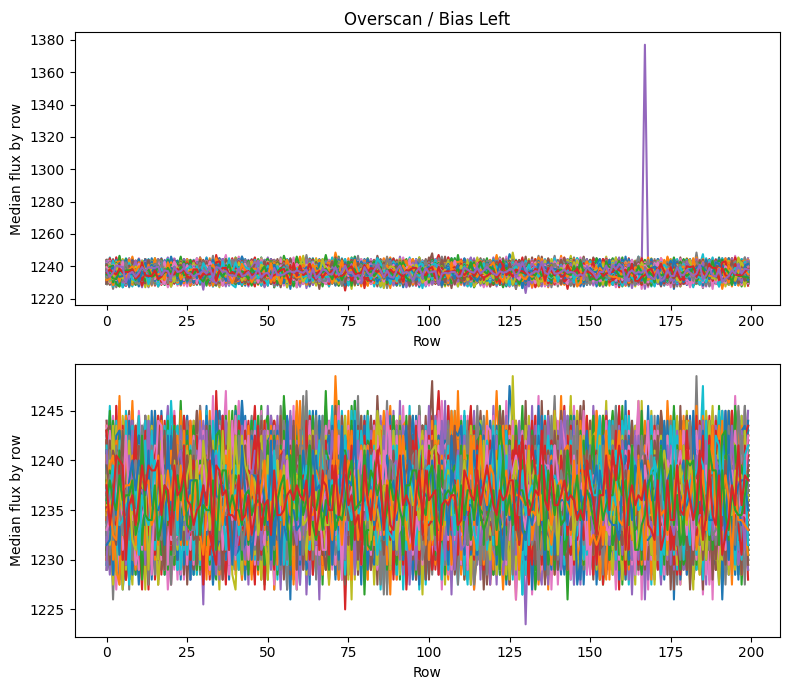

In [8]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8,7))
#y: median by row, x: row
for img in range(data_overscan_left.shape[0]):
    mean_overscan_left_row = np.array([np.median(data_overscan_left[img][x]) for x in range(0,data_overscan_left[img].shape[0])])
    axes[0].plot(np.arange(0,data_overscan_left.shape[1]),mean_overscan_left_row)
    for row,flux in enumerate(mean_overscan_left_row):
        if flux > 1300:
            print(f"Outlier with median flux {row} at row {flux} in the figure number {img}")
axes[0].set_xlabel("Row"); axes[0].set_ylabel("Median flux by row")

#y: median by row, x: row
for img in range(data_overscan_left.shape[0]):
    if img != 944:
        mean_overscan_left_row = np.array([np.median(data_overscan_left[img][x]) for x in range(0,data_overscan_left[img].shape[0])])
        axes[1].plot(np.arange(0,data_overscan_left.shape[1]),mean_overscan_left_row)
axes[1].set_xlabel("Row"); axes[1].set_ylabel("Median flux by row")
axes[0].set_title("Overscan / Bias Left")
plt.tight_layout()
plt.savefig("overscan_left_median.png")

In [9]:
list_outliers.append(944)

The bias counts distribution normally is close to a Gaussian.

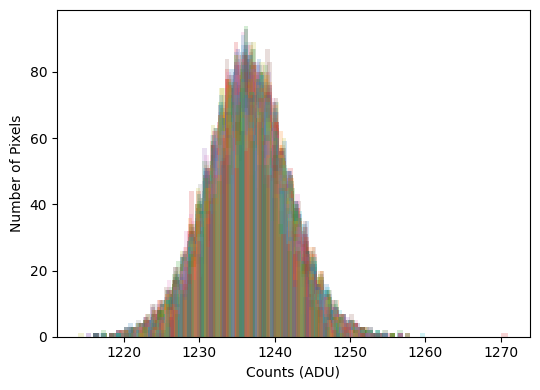

In [10]:
plt.figure(figsize=(5.5,4))
n_bins=50
for img in range(data_overscan_left.shape[0]): 
    if img == 944:
        continue
    result = data_overscan_left[img].flatten()

    plt.hist(result, bins = n_bins, histtype='stepfilled', alpha=0.2)

plt.xlabel("Counts (ADU)"); plt.ylabel("Number of Pixels")
plt.tight_layout()
plt.savefig("gaussians_bias.png")

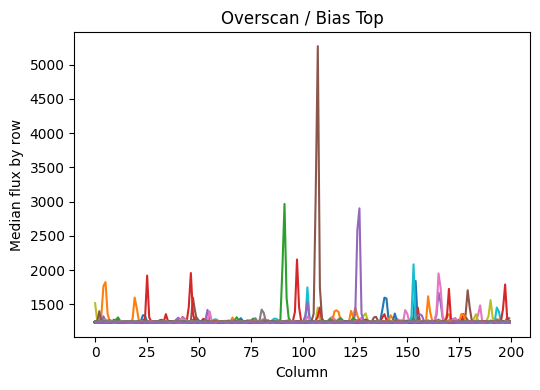

In [11]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(5.5,4))
#y: median by row, x: row
for img in range(data_overscan_top.shape[0]):
    mean_overscan_top_col = np.array([np.median(data_overscan_top[img][:,x]) for x in range(0,data_overscan_top[img].shape[1])])
    axes.plot(mean_overscan_top_col)
axes.set_xlabel("Column")
axes.set_ylabel("Median flux by row")
axes.set_title("Overscan / Bias Top")
plt.tight_layout()
plt.savefig("overscan_top_median.png")

Now seeing the standard deviation for each image, we reach the same conclusion of the outlier.

Here the mean and median of flux of each image. The mean varies a bit, and is sensitive to the outlier, while the median fluctuates between around three values.

As it varies in time, doing a single Master overscan/bias is not recommended, being a better option doing one single Master bias for each image.

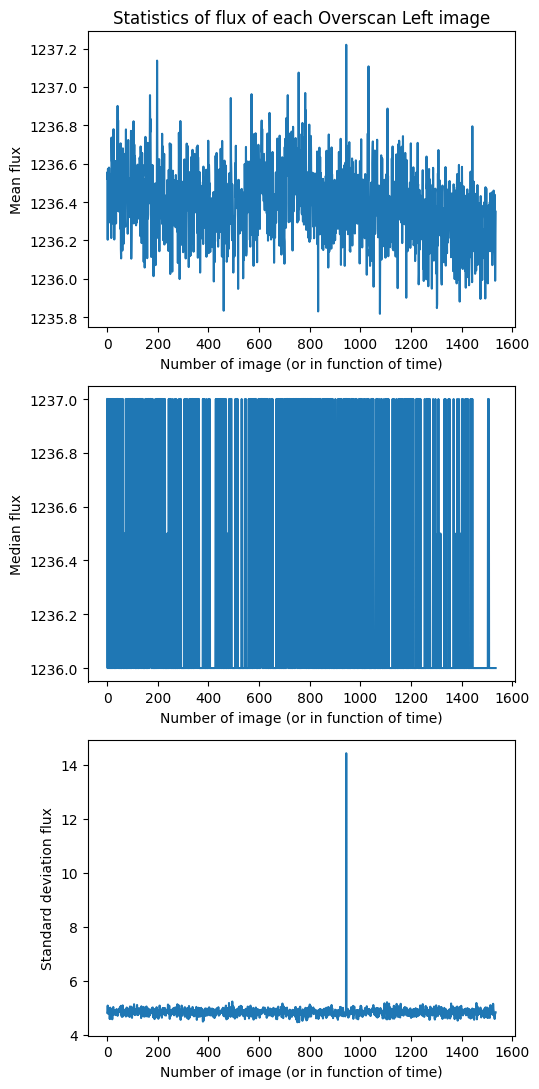

In [12]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(5.5,11))
for i,stat in enumerate(["Mean","Median","Standard deviation"]):
    stat_array = plot_flux_statistic_by_img(statistic=stat,data=data_overscan_left)
    axes[i].plot(np.arange(0,data_overscan_left.shape[0]),stat_array)
    axes[i].set_ylabel(f"{stat} flux") 
    axes[i].set_xlabel("Number of image (or in function of time)")
axes[0].set_title(f"Statistics of flux of each Overscan Left image")
plt.tight_layout()
plt.savefig("overscan_left_statistics.png")

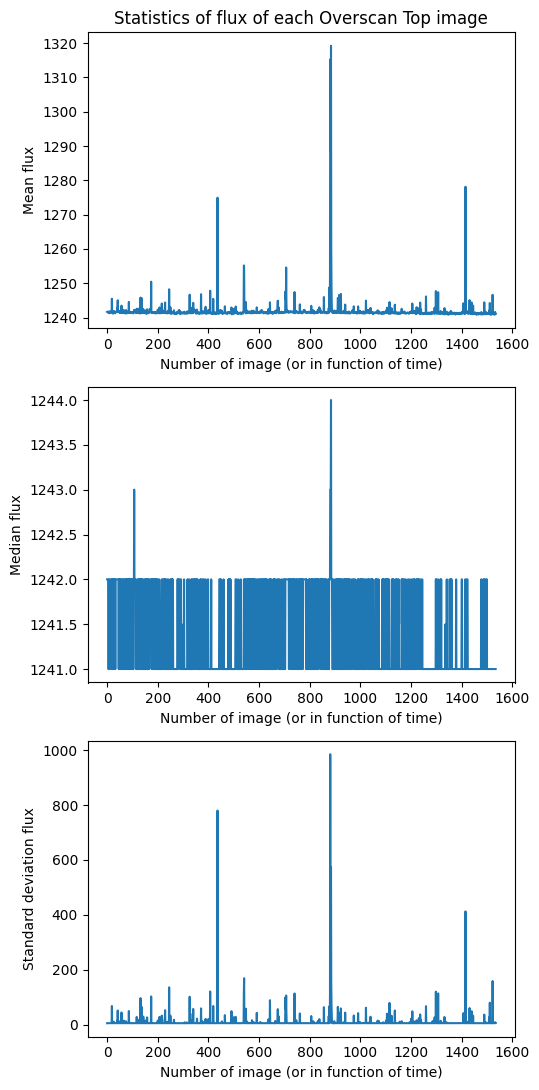

In [13]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(5.5,11))
for i,stat in enumerate(["Mean","Median","Standard deviation"]):
    stat_array = plot_flux_statistic_by_img(statistic=stat,data=data_overscan_top)
    axes[i].plot(stat_array)
    axes[i].set_ylabel(f"{stat} flux") 
    axes[i].set_xlabel("Number of image (or in function of time)")
axes[0].set_title(f"Statistics of flux of each Overscan Top image")
plt.tight_layout()
plt.savefig("overscan_top_statistics.png")

In [14]:
data_overscan = np.zeros((data_sub_array.shape[0],data_sub_array.shape[1],data_sub_array.shape[2]))
master_overscan = np.zeros((data_sub_array.shape[0],data_sub_array.shape[1],1))
for img in range(data_sub_array.shape[0]):
    master_overscan[img] = np.median(data_overscan_left[img],axis=1,keepdims=True)
    data_overscan[img] = data_sub_array[img].astype(float) - master_overscan[img]

hdr = fits.Header()
hdr['COMMENT']='Overscan/bias corrected'
hdr['COMMENT1']="Outside of circle points are negative"
file_name="files_corrected/bias/data_b.fits" 
fits.writeto(file_name,data_overscan,hdr,overwrite=True) 

hdr = fits.Header()
hdr['COMMENT']='Master Overscan'
file_name="files_corrected/bias/master_overscan.fits"
fits.writeto(file_name,master_overscan,hdr,overwrite=True) 

What I decided to do:

- master_overscan: median of the overscan image for each image
- take the median of each row of the master_overscan in order to compress it to 1D
- subtracting each value of the 1D master_overscan to the correspondent row of the subarray image

Used median instead of mean because of possible outliers. Median is more insensitive.

## Dark

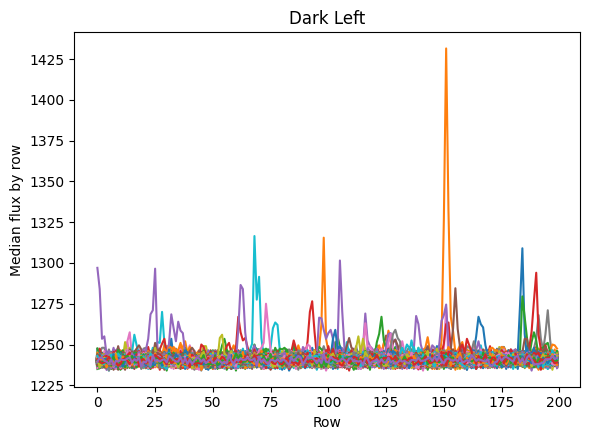

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(6,4.5))
#y: median by row, x: row
for img in range(data_overscan_top.shape[0]):
    median_dark_left_row = np.array([np.median(data_dark_left[img][x]) for x in range(0,data_dark_left[img].shape[0])])
    axes.plot(median_dark_left_row)
axes.set_xlabel("Row"); axes.set_ylabel("Median flux by row")
axes.set_title("Dark Left")
plt.tight_layout()
plt.savefig("dark_left_median.png")

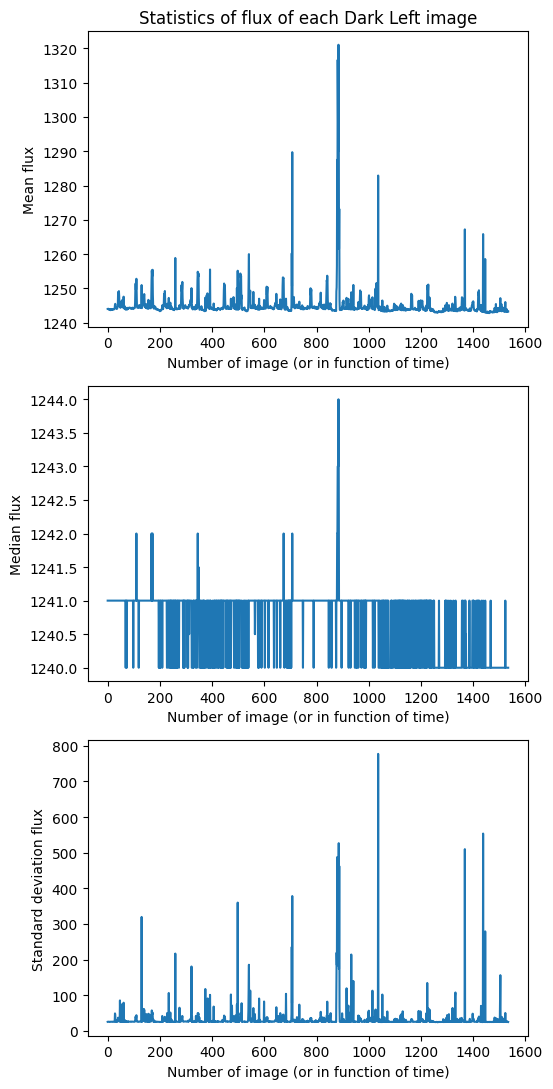

In [16]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(5.5,11))
for i,stat in enumerate(["Mean","Median","Standard deviation"]):
    stat_array = plot_flux_statistic_by_img(statistic=stat,data=data_dark_left)
    axes[i].plot(np.arange(0,data_dark_left.shape[0]),stat_array)
    axes[i].set_ylabel(f"{stat} flux") 
    axes[i].set_xlabel("Number of image (or in function of time)")
axes[0].set_title(f"Statistics of flux of each Dark Left image")
plt.tight_layout()
plt.savefig("dark_left_statistics.png")

In [17]:
std_dark_left = np.array(plot_flux_statistic_by_img(statistic=stat,data=data_dark_left))

for n,x in enumerate(std_dark_left):
    if x > 200:
        #print(n)
        list_outliers.append(n)

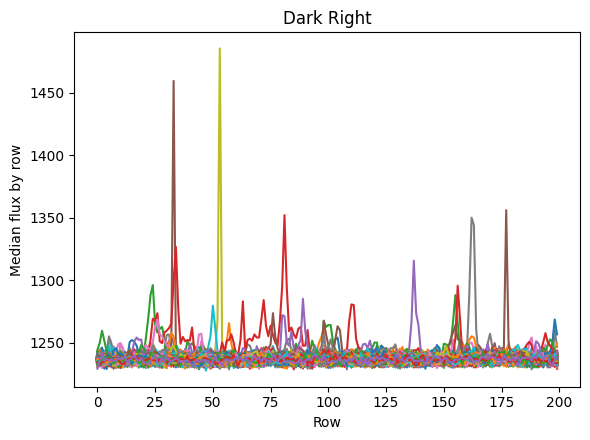

In [18]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(6,4.5))
#y: median by row, x: row
for img in range(data_dark_right.shape[0]):
    median_dark_right_row = np.array([np.median(data_dark_right[img][x]) for x in range(0,data_dark_right[img].shape[0])])
    axes.plot(median_dark_right_row)
axes.set_xlabel("Row"); axes.set_ylabel("Median flux by row")
axes.set_title("Dark Right")
plt.tight_layout()
plt.savefig("dark_right_median.png")

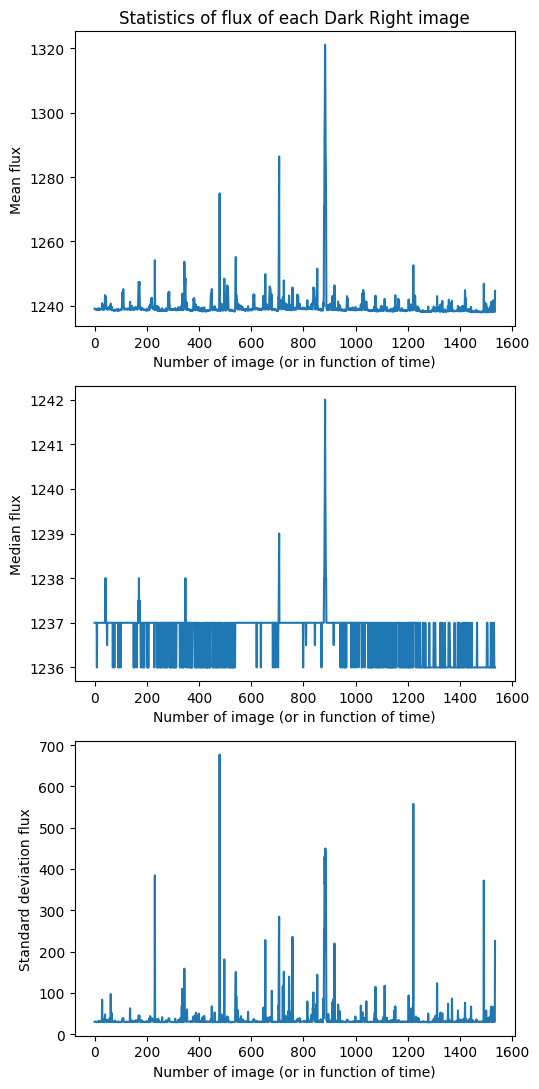

In [19]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(5.5,11))
for i,stat in enumerate(["Mean","Median","Standard deviation"]):
    stat_array = plot_flux_statistic_by_img(statistic=stat,data=data_dark_right)
    axes[i].plot(np.arange(0,data_dark_right.shape[0]),stat_array)
    axes[i].set_ylabel(f"{stat} flux") 
    axes[i].set_xlabel("Number of image (or in function of time)")
axes[0].set_title(f"Statistics of flux of each Dark Right image")
plt.tight_layout()
plt.savefig("dark_right_statistics.png")

In [20]:
std_dark_right = np.array(plot_flux_statistic_by_img(statistic=stat,data=data_dark_right))

for n,x in enumerate(std_dark_right):
    if x > 200:
        #print(n)
        list_outliers.append(n)

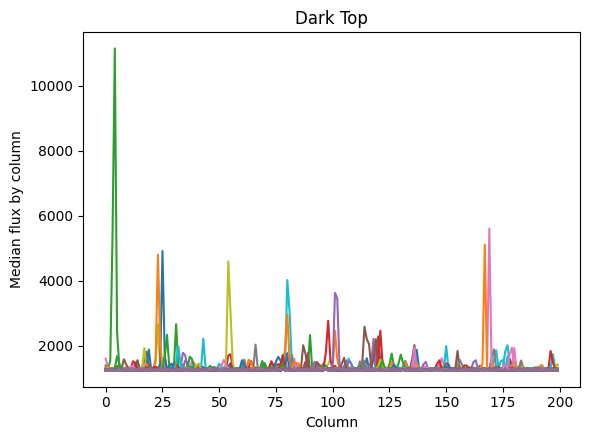

In [21]:
fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(6,4.5))
#y: median by row, x: row
for img in range(data_dark_top.shape[0]):
    median_dark_top_col = np.array([np.median(data_dark_top[img][:,x]) for x in range(0,data_dark_top[img].shape[1])])
    axes.plot(median_dark_top_col)
axes.set_xlabel("Column"); axes.set_ylabel("Median flux by column")
axes.set_title("Dark Top")
plt.tight_layout()
plt.savefig("dark_top_median.png")

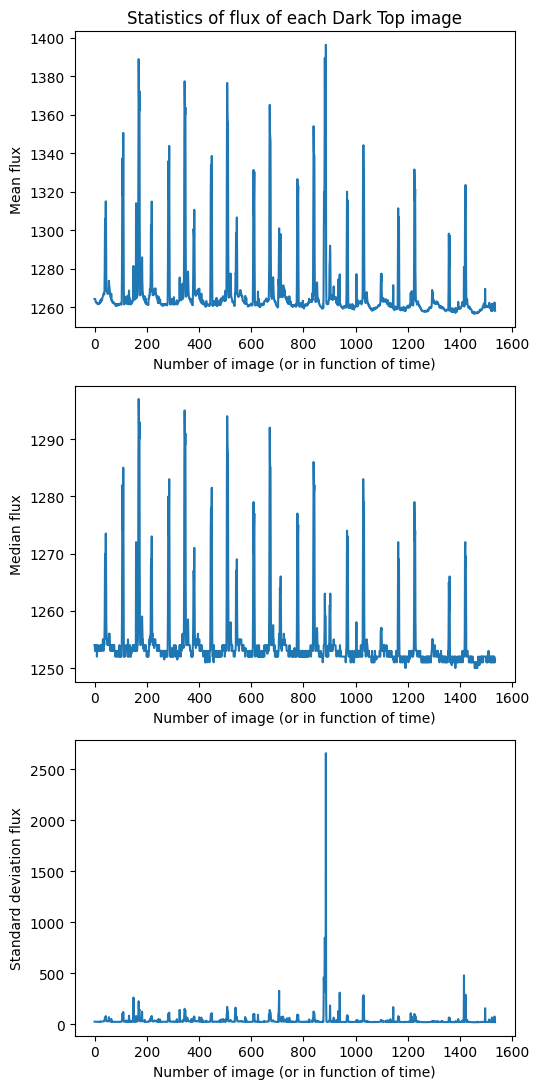

In [22]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(5.5,11))
for i,stat in enumerate(["Mean","Median","Standard deviation"]):
    stat_array = plot_flux_statistic_by_img(statistic=stat,data=data_dark_top)
    axes[i].plot(np.arange(0,data_dark_top.shape[0]),stat_array)
    axes[i].set_ylabel(f"{stat} flux") 
    axes[i].set_xlabel("Number of image (or in function of time)")
axes[0].set_title(f"Statistics of flux of each Dark Top image")
plt.tight_layout()
plt.savefig("dark_top_statistics.png")

Quality cut where every dark image with a standard deviation over 200 is cut.

In [23]:
std_dark_top = np.array(plot_flux_statistic_by_img(statistic=stat,data=data_dark_top))

for n,x in enumerate(std_dark_top):
    if x > 200:
        #print(n)
        list_outliers.append(n)

In [24]:
hdul = fits.open("files_corrected/bias/data_b.fits") 
data_bias = hdul[0].data
hdul.close()

hdul1 = fits.open("files_corrected/bias/master_overscan.fits") 
master_overscan = hdul1[0].data
hdul1.close()

In [25]:
data_dark = np.zeros((data_bias.shape[0],data_bias.shape[1],data_bias.shape[2]))
master_dark_left = np.zeros((data_bias.shape[0],data_bias.shape[1],1))
master_dark_right = np.zeros((data_bias.shape[0],data_bias.shape[1],1))
master_dark_top = np.zeros((data_bias.shape[0],1,data_bias.shape[2]))
for img in range(data_bias.shape[0]):

    data_dark_left[img] -= master_overscan[img]
    data_dark_right[img] -= master_overscan[img]
    data_dark_top[img] -= np.transpose(master_overscan[img])
    
    master_dark_left[img] = np.median(data_dark_left[img], axis=1, keepdims=True)
    master_dark_right[img] = np.median(data_dark_right[img], axis=1, keepdims=True)
    master_dark_top[img] = np.median(data_dark_top[img], axis=0, keepdims=True)

    data_dark[img] = data_bias[img].astype(float) - master_dark_left[img]
    data_dark[img] = data_bias[img].astype(float) - master_dark_right[img]
    data_dark[img] = data_bias[img].astype(float) - master_dark_top[img]

In [26]:
hdr = fits.Header()
hdr['COMMENT']='Dark current corrected'
hdr['COMMENT1']="Outside of circle points are negative"
file_name="files_corrected/dark/data_bd.fits" 
fits.writeto(file_name,data_dark,hdr,overwrite=True) 

In [27]:
hdr = fits.Header()
hdr['COMMENT']='Master Dark Left'
file_name="files_corrected/dark/master_dark_left.fits"
fits.writeto(file_name,master_dark_left,hdr,overwrite=True) 

hdr = fits.Header()
hdr['COMMENT']='Master Dark Right'
file_name="files_corrected/dark/master_dark_right.fits"
fits.writeto(file_name,master_dark_right,hdr,overwrite=True) 

hdr = fits.Header()
hdr['COMMENT']='Master Dark Top'
file_name="files_corrected/dark/master_dark_top.fits"
fits.writeto(file_name,master_dark_top,hdr,overwrite=True) 

## Flatfield

In [28]:
hdr_flat_field

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  200                                                  
NAXIS2  =                  200                                                  
EXTEND  =                    T                                                  
FF_TEFF =               5410.0 / K                                              

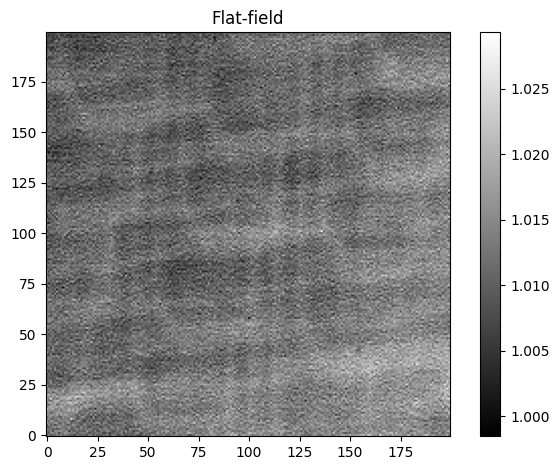

In [29]:
plot_img(data_flat_field,norm_mode="none")
plt.title("Flat-field")
plt.tight_layout()
plt.savefig("flatfield.png")

In [30]:
data_ff = np.zeros((data_dark.shape[0],data_dark.shape[1],data_dark.shape[2]))
for img in range(data_dark.shape[0]):
    data_ff[img] = data_dark[img].astype(float) / data_flat_field

In [31]:
hdr = fits.Header()
hdr['COMMENT']='Flat field corrected'
hdr['COMMENT1']="Outside of circle points are negative"
file_name="files_corrected/flatfielded/data_bdf.fits" 
fits.writeto(file_name,data_ff,hdr,overwrite=True) 

## Gain, RON and final calibrated images

Trying to compute the gain and RON from the bias counts.

In [32]:
gain_array = []; bias_sigma = []

for img in range(data_overscan_left.shape[0]):
    if img not in list_outliers:
        Gain = (np.sqrt(np.mean(data_overscan_left[img])) / np.std(data_overscan_left[img]))**2
        gain_array.append(Gain)
        bias_sigma.append(np.std(data_overscan_left[img]))

gain_array = np.array(gain_array)
bias_sigma = np.array(bias_sigma)

Text(0, 0.5, 'Gain (e-/ADU)')

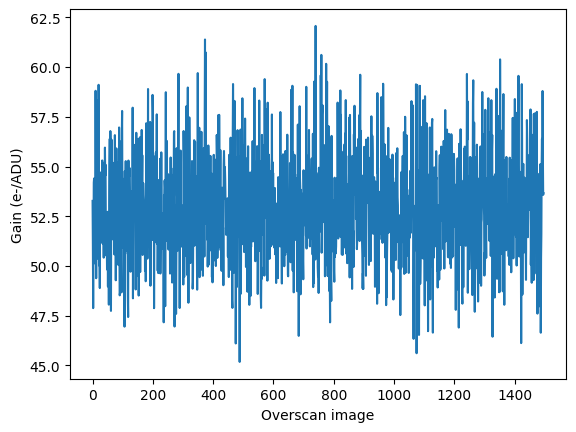

In [33]:
plt.figure(1)
plt.plot(gain_array)
plt.xlabel("Overscan image"); plt.ylabel("Gain (e-/ADU)")

In [34]:
gain_mean = np.mean(gain_array)
gain_mean

52.991989618763135

In [35]:
RON = gain_array*bias_sigma
ron_mean = np.mean(RON)
ron_mean

255.88911514272496

These results are not satisfatory, so I am going to use the values described in "The testing and characterization of the CHEOPS CCDs".

In [36]:
gain = 1/0.4390 #e- / ADU
ron = 5.35 #e- / pixel

In [37]:
with fits.open(path2files["SubArray"]) as hdul:
    data_sub_array = hdul[1].data

In [38]:
hdul = fits.open("files_corrected/flatfielded/data_bdf.fits")
data_calibrated = hdul[0].data

In [39]:
list_outliers.append(392) #esta está com um rasto no topo?
list_outliers = np.unique(np.array(list_outliers))
list_outliers

array([ 130,  149,  169,  231,  259,  392,  479,  498,  654,  705,  706,
        707,  758,  877,  878,  879,  880,  881,  882,  883,  884,  885,
        886,  887,  919,  933,  939,  944, 1028, 1030, 1036, 1221, 1368,
       1415, 1421, 1438, 1446, 1491, 1534])

Cutting the outliers from the data set.

In [40]:
# Create a mask to select the indices to keep
mask = np.ones(data_calibrated.shape[0], dtype=bool)
mask[list_outliers] = False

# Apply the mask to remove the selected indices
data_calibrated = data_calibrated[mask]
data_calibrated.shape

(1496, 200, 200)

In [41]:
for img in range(data_calibrated.shape[0]):
    data_ind = np.where((data_calibrated[img] < 0))
    data_calibrated[img][data_ind] = 0

    data_calibrated[img] *= gain

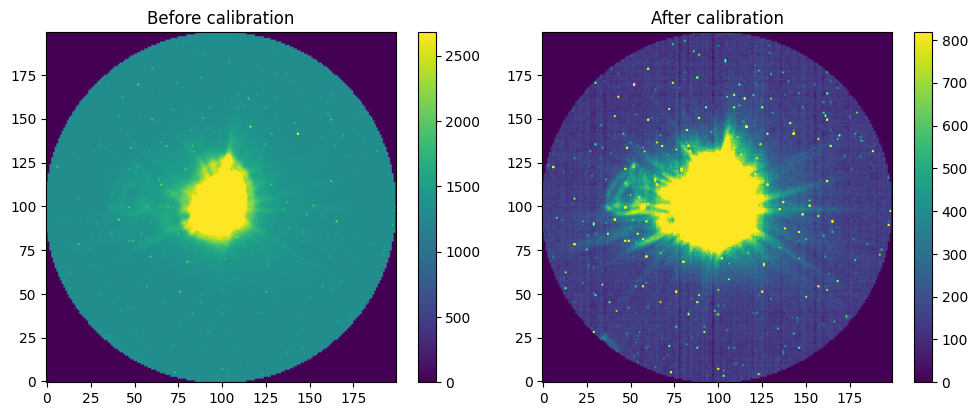

In [42]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

ind = 0

zscale = ZScaleInterval()
zlims = zscale.get_limits(data_sub_array[0])
norm = simple_norm(data_sub_array[ind], min_cut=zlims[0], max_cut=zlims[1])
im = axes[0].imshow(data_sub_array[ind], origin='lower', norm=norm, cmap=plt.get_cmap("viridis"))
cbar = fig.colorbar(im, ax=axes[0])
axes[0].set_title("Before calibration")

zlims = zscale.get_limits(data_calibrated[0])
norm = simple_norm(data_calibrated[ind], min_cut=zlims[0], max_cut=zlims[1])
im1 = axes[1].imshow(data_calibrated[ind], origin='lower', norm=norm, cmap=plt.get_cmap("viridis"))
pcbar1 = fig.colorbar(im1, ax=axes[1])
axes[1].set_title("After calibration")

plt.tight_layout()
plt.savefig("after_before_0.png")

# Correction

## Depointing: centroid calculation

### Manual

Computes the center of mass of the image by making use of the physical definition of center of mass. The coordinates of the center of mass are given by

$$ \textbf{R} = \frac{\Sigma^n_{i=1} m_i \textbf{r}_i}{\Sigma^n_{i=1} m_i} $$

where $m_i$ is the counts/flux in that pixel and $\textbf{r}_i$ is the pixel's coordinate. A threshold can also be defined.

This works fine for most images, but there are some where a background star has an unusual amount of flux/counts. We know where that star is located so there is an option of making a circular mask that considers the flux inside that circle, with a radius such that the background star is left out.

In [43]:
def create_circular_mask(shape, center, radius):
    #binary circular mask with the given shape, center and radius
    rows, cols = np.ogrid[:shape[0], :shape[1]]
    y, x = center
    mask = (rows - y)**2 + (cols - x)**2 <= radius**2
    return mask

def create_annulus_mask(shape, center, r_out, r_in):
    #binary annular mask with the given shape, center and radius
    rows, cols = np.ogrid[:shape[0], :shape[1]]
    y, x = center
    mask = ((rows - y)**2 + (cols - x)**2 <= r_out**2) & ((rows - y)**2 + (cols - x)**2 >= r_in**2)
    return mask

In [44]:
def get_centroids_manual(data, threshold, radius_mask=100, circular_mask=True):

    if circular_mask == True:
        center = (100, 100)  #center of the circular region
        radius = radius_mask  #radius of the circular region
        mask = create_circular_mask(data.shape, center, radius)
        data_circle = np.where(mask, data, 0)
        data_circle = (data_circle > threshold)
    else:
        data_circle = (data > threshold)
    
    #step 2: calculate moments
    y_coords, x_coords = np.mgrid[:data.shape[0], :data.shape[1]]
    total_mass = np.sum(data_circle)
    mass_x = np.sum(data_circle * x_coords)
    mass_y = np.sum(data_circle * y_coords)
    
    #step 3: center of mass
    center_of_mass_x = mass_x / total_mass
    center_of_mass_y = mass_y / total_mass
    
    return [center_of_mass_x,center_of_mass_y]

Std of background circles: [53.73893381 43.82994092 79.26172554 60.80267314]
Median std: 57.27080347667118


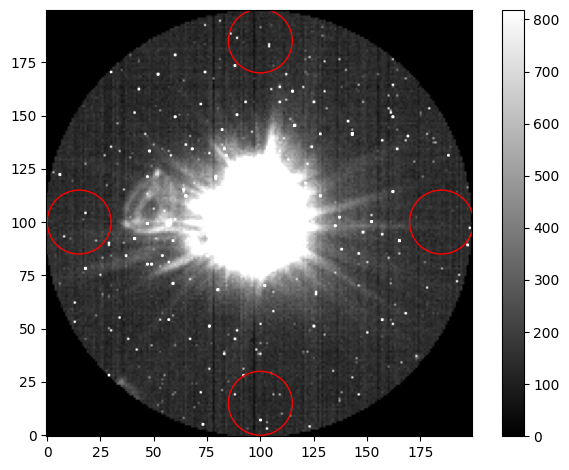

In [45]:
ind = 0
fig,ax = plot_img(data_calibrated[ind],norm_mode="simple")

#down, top, left, right
circles_bck = [(100,15),(100,185),(15,100),(185,100)]

std_circ_array = np.zeros((4))
for i,circ in enumerate(circles_bck):
    circ_bck = Circle(circ, 15, color='red',fill=None)
    ax.add_patch(circ_bck)

    mask_circ = create_circular_mask(shape=data_calibrated[ind].shape, center=circ, radius=15)
    circle_masked = data_calibrated[ind][mask_circ]
    final_circ = circle_masked[(circle_masked>0)]

    std_circ_array[i] = np.std(final_circ)

median_std = np.median(std_circ_array)
print("Std of background circles:",std_circ_array)
print("Median std:",median_std)

plt.tight_layout()
plt.savefig("example_circ_bck.png")

In [46]:
def background_std(data_calibrated):
    #down, top, left, right
    circles_bck = [(100,15),(100,185),(15,100),(185,100)]
    median_std_array = np.zeros((data_calibrated.shape[0]))
    for n,ind in enumerate(range(data_calibrated.shape[0])):
        
        std_circ_array = np.zeros((4))
        for i,circ in enumerate(circles_bck):
            mask_circ = create_circular_mask(shape=data_calibrated[ind].shape, center=circ, radius=15)
            circle_masked = data_calibrated[ind][mask_circ]
            final_circ = circle_masked[(circle_masked>0)]
        
            std_circ_array[i] = np.std(final_circ)
        
        median_std_array[n] = np.median(std_circ_array)
        
    return median_std_array

threshold_array = background_std(data_calibrated)*100 #100sigma

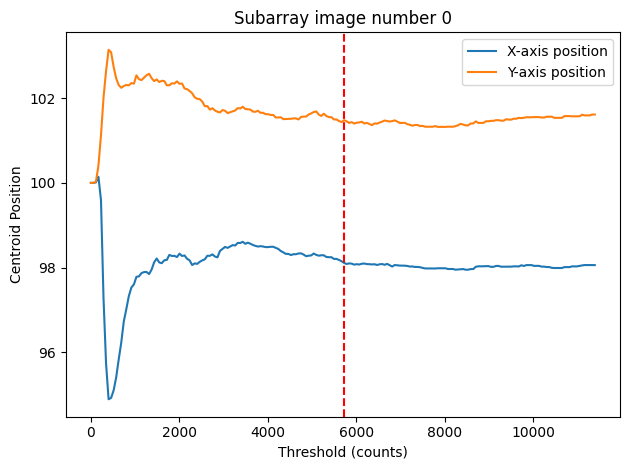

In [116]:
ind = 0
image = data_calibrated[ind]

threshold_list = np.linspace(0,5000*gain,200)
positions_manual = np.zeros((200,2))

for i,threshold_value in enumerate(threshold_list):

    positions = get_centroids_manual(image, threshold_value, radius_mask=50, circular_mask=True)

    positions_manual[i,0] = positions[0]
    positions_manual[i,1] = positions[1]
    
#print(positions_manual)

plt.figure(1)
plt.plot(threshold_list,positions_manual[:,0],label="X-axis position")
plt.plot(threshold_list,positions_manual[:,1],label="Y-axis position")
plt.axvline(threshold_array[0],ls="--",color="red")
plt.xlabel("Threshold (counts)"); plt.ylabel("Centroid Position"); plt.title(f"Subarray image number {ind}")
plt.legend()
plt.tight_layout()
plt.savefig("threshold_array_example_0.png")

In [48]:
positions_manual = np.zeros((data_calibrated.shape[0],2))

progress = tqdm.tqdm(range(data_calibrated.shape[0]))
for n in progress:
    time.sleep(0.001)
    
    image = data_calibrated[n]

    positions = get_centroids_manual(image, threshold_array[n], radius_mask=50, circular_mask=False)

    positions_manual[n,0] = positions[0]
    positions_manual[n,1] = positions[1]

    #plot_img(image,norm_mode="simple")
    #plt.scatter(center_of_mass_x, center_of_mass_y, color='red', marker='x', label='Star Center')
positions_manual

100%|█████████████████████████████████████████████████████████████████████████████| 1496/1496 [00:02<00:00, 632.19it/s]


array([[ 98.15671642, 101.50124378],
       [ 98.70171149, 102.08801956],
       [ 99.77654321, 101.69135802],
       ...,
       [100.10299401, 101.93053892],
       [ 99.7309185 , 101.76714101],
       [ 98.9270073 , 101.85888078]])

### Skimage

This method didn't give the expected results so we are not going to use this one.

In [49]:
def get_centroids_skimage(data, threshold, radius_mask=100, circular_mask=True):

    if circular_mask == True:
        center = (100, 100)  #center of the circular region
        radius = radius_mask  #radius of the circular region
        mask = create_circular_mask(data.shape, center, radius)
        data_circle = np.where(mask, data, 0)
        data_circle = (data_circle > threshold)
    else:
        data_circle = (data > threshold)
    data_circle = data
    
    #step 1: thresholding
    threshold_value = filters.threshold_otsu(data_circle)
    thresholded_data = data_circle > threshold_value
    #step 2: Label connected regions
    labeled_data, num_labels = label(thresholded_data)
    #center of mass for each labeled region
    centers = [center_of_mass(thresholded_data, labeled_data, index=i) for i in range(1, num_labels+1)]
    center_x = centers[0][0]
    center_y = centers[0][1]
    
    return [center_x,center_y]

In [50]:
positions_skimage = np.zeros((data_calibrated.shape[0],2))
threshold = 2000
progress = tqdm.tqdm(range(data_calibrated.shape[0]))
for n in progress:
    time.sleep(0.001)

    image = data_calibrated[n]
    
    positions = get_centroids_skimage(image, threshold, radius_mask=100, circular_mask=True)

    positions_skimage[n,0] = positions[0]
    positions_skimage[n,1] = positions[1]
    
positions_skimage

100%|█████████████████████████████████████████████████████████████████████████████| 1496/1496 [00:04<00:00, 333.26it/s]


array([[101.58178439,  98.17472119],
       [102.05595668,  98.69855596],
       [101.67706422,  99.73761468],
       ...,
       [101.91818182, 100.01454545],
       [101.90328467,  99.62773723],
       [101.83918669,  98.86876155]])

### DAOStarFinder

DAOStarFinder algorithm from the phot_utils module.

In [60]:
def get_centroids_daostarfinder(data, fwhmpsf):
    
    media, mediana, bkg_sigma = sigma_clipped_stats(data, sigma=3)
    spatial = fwhmpsf
    threshold=100*bkg_sigma
    
    daofind = DAOStarFinder(fwhm=spatial, threshold= threshold, brightest=1)
    sources = daofind(data)

    center_x = sources['xcentroid'][0]
    center_y = sources['ycentroid'][0]
    
    return [center_x,center_y]

In [61]:
positions_daostarfinder = np.zeros((data_calibrated.shape[0],2))

progress = tqdm.tqdm(range(data_calibrated.shape[0]))
for n in progress:
    time.sleep(.001)

    image = data_calibrated[n]
    
    positions = get_centroids_daostarfinder(image, fwhmpsf=18)
    
    positions_daostarfinder[n,0] = positions[0]
    positions_daostarfinder[n,1] = positions[1]

positions_daostarfinder

100%|██████████████████████████████████████████████████████████████████████████████| 1496/1496 [01:11<00:00, 20.95it/s]


array([[102.15906822,  95.64526882],
       [102.65163078,  96.10493967],
       [103.77834966,  95.83761258],
       ...,
       [104.04494031,  95.93082785],
       [103.69911026,  95.97243692],
       [102.93126355,  95.89698255]])

To choose the best FWHM to use in this method, we plotted the centroid position vs FWHM.

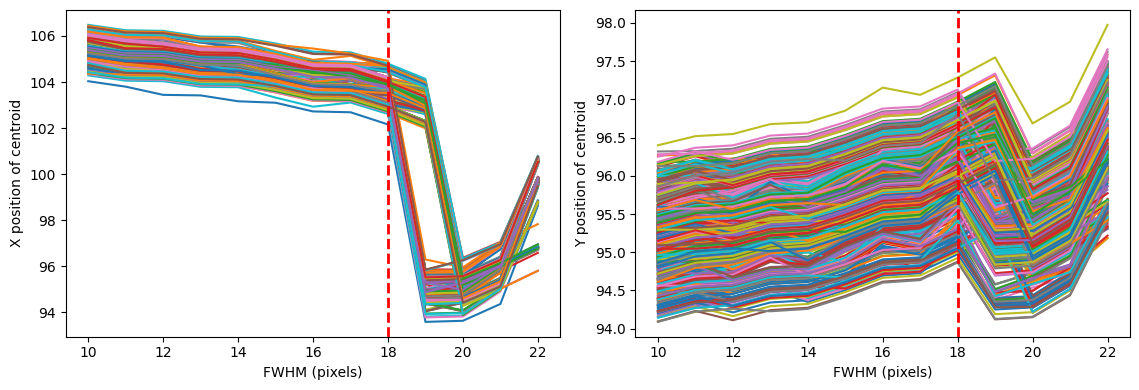

In [53]:
fwhm_array = np.arange(10,23,1)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(11.5,4))

for img in range(data_calibrated.shape[0]):
    
    positions_daostarfinder = np.zeros((fwhm_array.shape[0],2))
    for n,fwhm in enumerate(fwhm_array):
    
        positions = get_centroids_daostarfinder(data_calibrated[img], fwhmpsf=fwhm)
        
        positions_daostarfinder[n,0] = positions[0]
        positions_daostarfinder[n,1] = positions[1]

    axes[0].plot(fwhm_array,positions_daostarfinder[:,0])
    axes[1].plot(fwhm_array,positions_daostarfinder[:,1])
    
axes[0].axvline(18,ls="--",c="red",lw=2)
axes[1].axvline(18,ls="--",c="red",lw=2)
axes[0].set_xlabel("FWHM (pixels)"); axes[0].set_ylabel("X position of centroid")
axes[1].set_xlabel("FWHM (pixels)"); axes[1].set_ylabel("Y position of centroid")
plt.tight_layout()
plt.savefig("fwhm_centroid.png")

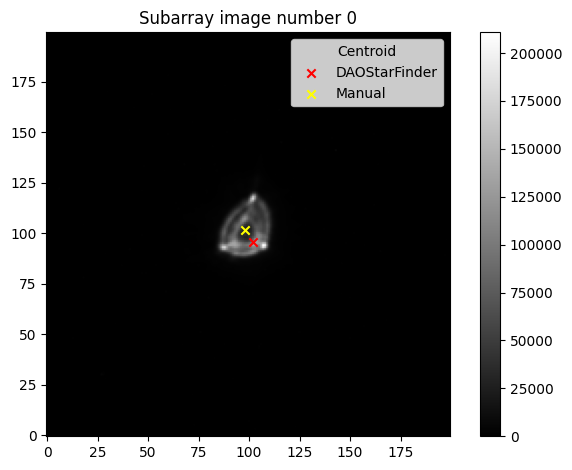

In [62]:
ind = 0
plot_img(image,norm_mode="none")
plt.scatter(positions_daostarfinder[ind,0], positions_daostarfinder[ind,1], color='red', marker='x', label='DAOStarFinder')
plt.scatter(positions_manual[ind,0], positions_manual[ind,1], color='yellow', marker='x', label='Manual')
plt.legend(title="Centroid")
plt.title(f"Subarray image number {ind}")
plt.tight_layout()
plt.savefig("centroids_methods_0.png")

MJD time to BJD.

In [63]:
BJD = data_metadata['MJD_TIME']+2400000.5-2458918
# Create a mask to select the indices to keep
mask = np.ones(BJD.shape[0], dtype=bool)
mask[list_outliers] = False

# Apply the mask to remove the selected indices
BJD = BJD[mask]
BJD

array([0.1193353 , 0.1196831 , 0.1200309 , ..., 0.69737893, 0.69772673,
       0.69807453])

In [64]:
x_positions_manual = [pos[0] for pos in positions_manual]
y_positions_manual = [pos[1] for pos in positions_manual]

x_positions_daostarfinder = [pos[0] for pos in positions_daostarfinder]
y_positions_daostarfinder = [pos[1] for pos in positions_daostarfinder]

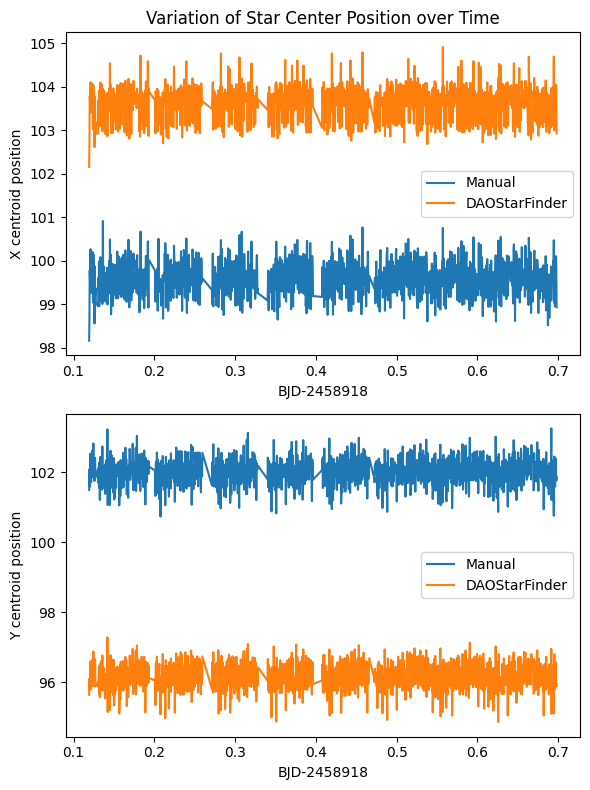

In [65]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(6,8))

axes[0].plot(BJD, x_positions_manual, label='Manual')
axes[0].plot(BJD, x_positions_daostarfinder, label='DAOStarFinder')
axes[0].set_xlabel('BJD-2458918')
axes[0].set_ylabel('X centroid position')
axes[0].legend()

axes[1].plot(BJD, y_positions_manual, label='Manual')
axes[1].plot(BJD, y_positions_daostarfinder, label='DAOStarFinder')
axes[1].set_xlabel('BJD-2458918')
axes[1].set_ylabel('Y centroid position')
axes[1].legend()

axes[0].set_title('Variation of Star Center Position over Time')
plt.tight_layout()
plt.savefig("variation_center.png")

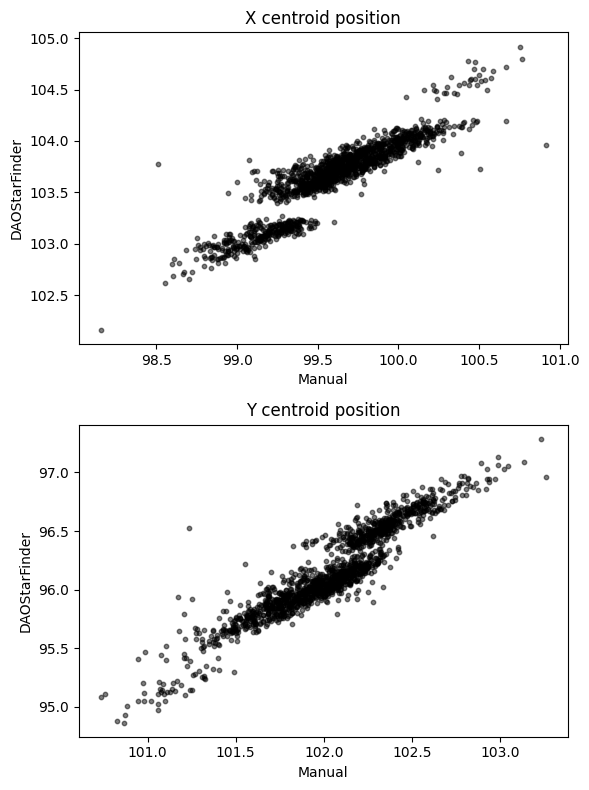

In [66]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(6,8))

axes[0].scatter(x_positions_manual, x_positions_daostarfinder,color="black",alpha=0.5,s=10)
axes[0].set_xlabel("Manual")
axes[0].set_ylabel("DAOStarFinder")
axes[0].set_title("X centroid position")

axes[1].scatter(y_positions_manual, y_positions_daostarfinder,color="black",alpha=0.5,s=10)
axes[1].set_xlabel("Manual")
axes[1].set_ylabel("DAOStarFinder")
axes[1].set_title("Y centroid position")

plt.tight_layout()
plt.savefig("positions_compare.png")

# Aperture Photometry

## Phot_utils

In [67]:
def aperture_photom_photutils(data, positions, aperture_radius=33):
    
    aperturesPhotom = CircularAperture(positions, r=aperture_radius)

    phot_table = aperture_photometry(data, aperturesPhotom)

    annulus_aperture = CircularAnnulus(positions, r_in=aperture_radius+30, r_out=aperture_radius+35) 
        
    aperstats = ApertureStats(data, annulus_aperture)

    area_annulus = np.pi* (aperture_radius)**2
    
    phot_table['annulus_median'] = aperstats.median
    aper_bkg = area_annulus * phot_table['annulus_median']
    phot_table["aper_bkg"] = aper_bkg
    aper_sum_bkgsub = phot_table["aperture_sum"]-phot_table["aper_bkg"]
    phot_table["aper_sum_bkgsub"] = aper_sum_bkgsub
    
    return aper_sum_bkgsub[0], phot_table['annulus_median'][0]

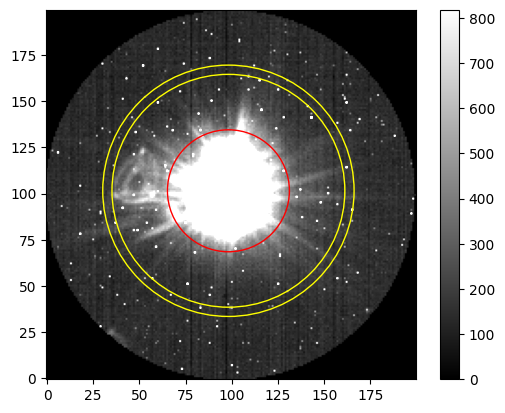

In [68]:
fig, ax = plot_img(data_calibrated[0],norm_mode="simple")

aperture_radius = 33
circ_aperture = Circle(positions_manual[0], aperture_radius, color='red',fill=None)
circ_annulus_1 = Circle(positions_manual[0], aperture_radius+30, color='yellow',fill=None)
circ_annulus_2 = Circle(positions_manual[0], aperture_radius+35, color='yellow',fill=None)
ax.add_patch(circ_aperture)
ax.add_patch(circ_annulus_1)
ax.add_patch(circ_annulus_2)
plt.savefig("rings_star_0.png")

In [70]:
flux_photutils = np.zeros((data_calibrated.shape[0]))

progress = tqdm.tqdm(range(data_calibrated.shape[0]))
for img in progress:
    time.sleep(.001)
    aper_sum_bkgsub, annulus_median = aperture_photom_photutils(data_calibrated[img], positions_daostarfinder[img], aperture_radius = 33)
    flux_photutils[img] = aper_sum_bkgsub

100%|█████████████████████████████████████████████████████████████████████████████| 1496/1496 [00:05<00:00, 293.25it/s]


## Manual

Basically same thing as the phot_utils method but all manually done.

In [71]:
def aperture_photom_manual(data, positions, aperture_radius = 33):

    #sum of the aperture
    mask = create_circular_mask(data.shape, positions, aperture_radius)
    data_aperture = np.where(mask, data, 0)
    aperture_sum = np.sum(data_aperture)

    #annulus to compute the bck
    r_in=aperture_radius+30; r_out=r_in+5
    mask_annulus = create_annulus_mask(data.shape, positions, r_out, r_in)
    annulus_aperture = np.where(mask_annulus, data, 0)
    annulus_median = np.median(annulus_aperture[annulus_aperture != 0])

    #computing the background
    area_annulus = np.pi* (aperture_radius)**2
    aper_bkg = area_annulus * annulus_median
    
    aper_sum_bkgsub = aperture_sum - aper_bkg
    
    return aper_sum_bkgsub, annulus_median

In [72]:
flux_manual = np.zeros((data_calibrated.shape[0]))

progress = tqdm.tqdm(range(data_calibrated.shape[0]))
for img in progress:
    time.sleep(.001)
    aper_sum_bkgsub, annulus_median = aperture_photom_manual(data_calibrated[img], positions_manual[img], aperture_radius = 33)
    flux_manual[img] = aper_sum_bkgsub

100%|█████████████████████████████████████████████████████████████████████████████| 1496/1496 [00:02<00:00, 550.15it/s]


## Growth curve

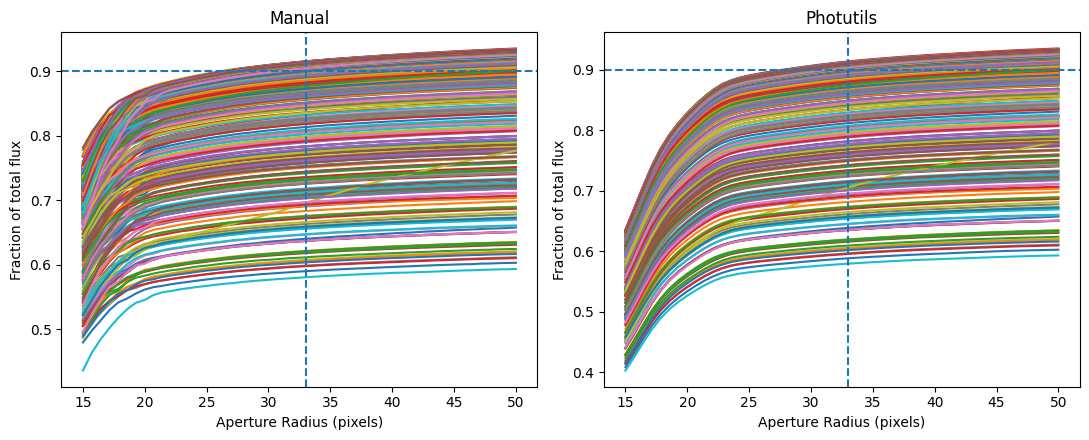

In [75]:
aperture_radius_array = np.linspace(15,50,50)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(11,4.5))

for img in range(data_calibrated.shape[0]):
    flux_array_manual = np.zeros((aperture_radius_array.shape[0]))
    flux_array_photutils = np.zeros((aperture_radius_array.shape[0]))
    for i,rad in enumerate(aperture_radius_array):
        aper_sum_bkgsub,annulus_median = aperture_photom_manual(data_calibrated[img], positions_manual[img], aperture_radius = rad)
        flux_array_manual[i] = aper_sum_bkgsub

        aper_sum_bkgsub,annulus_median = aperture_photom_photutils(data_calibrated[img], positions_daostarfinder[img], aperture_radius = rad)
        flux_array_photutils[i] = aper_sum_bkgsub 
        
    #if flux_array_manual[-1] > 2.2*10**7: print("Pink curve manual: ",img)
    #if flux_array_photutils[-1] > 2.2*10**7: print("Pink curve photutils: ",img)
    axes[0].plot(aperture_radius_array, flux_array_manual/np.sum(data_calibrated[img]))
    axes[1].plot(aperture_radius_array, flux_array_photutils/np.sum(data_calibrated[img]))
axes[0].axvline(33,ls="--")
axes[1].axvline(33,ls="--")
axes[0].axhline(0.9,ls="--")
axes[1].axhline(0.9,ls="--")
axes[0].set_xlabel("Aperture Radius (pixels)"); axes[0].set_ylabel("Fraction of total flux")
axes[0].set_title("Manual")
axes[1].set_xlabel("Aperture Radius (pixels)"); axes[1].set_ylabel("Fraction of total flux")
axes[1].set_title("Photutils")

plt.tight_layout()
plt.savefig("photometry_growth_curve.png")

## SNR and flux error

Using the CCD equation and the manual centroid and aperture photometry methods.

In [76]:
SNR_array = np.zeros((data_calibrated.shape[0]))
rad = 33
N_pix = np.pi * rad**2

for img in range(data_calibrated.shape[0]):
    aper_sum_bkgsub,annulus_median = aperture_photom_manual(data_calibrated[img], positions_manual[img], aperture_radius = rad)

    BS = annulus_median*N_pix
    F = aper_sum_bkgsub
    BR = ron_mean
    dark_median = [plot_flux_statistic_by_img("Median",np.array([data_dark_top[img]]))[0],
                   plot_flux_statistic_by_img("Median",np.array([data_dark_left[img]]))[0],
                   plot_flux_statistic_by_img("Median",np.array([data_dark_right[img]]))[0]]

    BD = np.median(dark_median) * gain_mean
    SNR = F/np.sqrt(F + N_pix * (BS+BD+BR**2))
    SNR_array[img] = SNR
SNR_array

array([ 990.27303499,  995.95589737,  992.00958656, ..., 1177.57137507,
       1166.75781932, 1163.52290874])

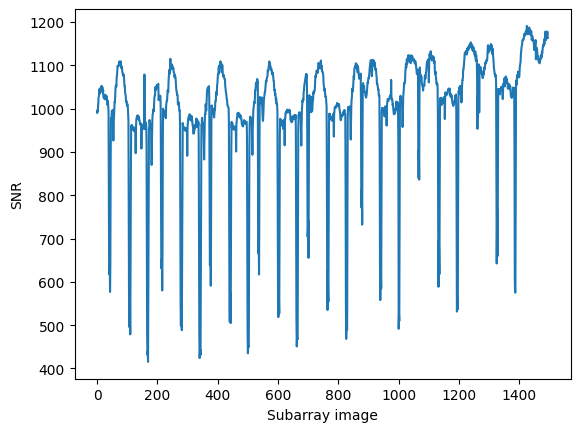

In [77]:
plt.plot(SNR_array)
plt.xlabel("Subarray image"); plt.ylabel("SNR")
plt.savefig("SNR.png")

Now I'm going to compute the flux error using the equation described in "ARCHI: pipeline for light curve extraction of CHEOPS background stars"

\begin{equation}
    \text{Err} = \sqrt{\begin{aligned}[t]
    & F + bg + N_\text{pix} \times N_\text{stack} \times (\text{gain} \times \text{RON})^2 \\
    & + \text{dark} \times t_\text{exposure} \times N_\text{pix}
    \end{aligned}}
\end{equation}

where $bg = \text{background} \times N_\text{pix} \times t_\text{exposure}$

In [78]:
list_hdr = [hdr_sub_array,hdr_dark_left,hdr_dark_right,hdr_dark_top,hdr_overscan_left]
for hdr in list_hdr:
    print("N_stack: ",hdr["NEXP"])

N_stack:  2
N_stack:  2
N_stack:  2
N_stack:  2
N_stack:  2


In [79]:
list_hdr = [hdr_sub_array,hdr_dark_left,hdr_dark_right,hdr_dark_top,hdr_overscan_left]
for hdr in list_hdr:
    print("t_exp: ",hdr["EXPTIME"])

t_exp:  15.0
t_exp:  15.0
t_exp:  15.0
t_exp:  15.0
t_exp:  15.0


In [80]:
rad = 33
N_pix = np.pi * rad**2
t_exposure = 30
Nstack = 2

flux_error = np.zeros((data_calibrated.shape[0]))
flux_error_1 = np.zeros((data_calibrated.shape[0]))
for img in range(data_calibrated.shape[0]):
    median_dark = plot_flux_statistic_by_img("Median",np.array([data_dark_top[img]]))[0]
    aper_sum_bkgsub,annulus_median = aperture_photom_manual(data_calibrated[img], positions_manual[img], aperture_radius = rad)

    F = aper_sum_bkgsub
    background = annulus_median
    bg = background * N_pix * t_exposure
    dark = median_dark*gain_mean

    Err = np.sqrt( F +  bg +  N_pix * Nstack * (ron_mean)**2 + dark * t_exposure * N_pix)
    
    flux_error[img] = Err
    flux_error_1[img] = Err/F*100

flux_manual_err = flux_error

In [81]:
print("Mean flux error %: ",np.mean(flux_error_1))

Mean flux error %:  0.05309148569832998


# Light curve

Finally, plotting the light curve by normalizing the flux and computing an estimate for the planet's radius.

In [110]:
def bin_time(BJD, flux, bin_width):
    bin_edges = np.arange(BJD.min(), BJD.max() + bin_width, bin_width)
    bin_indices = np.digitize(BJD, bin_edges)
    median_flux_values = [np.median(flux[bin_indices == i]) for i in range(1, len(bin_edges))]
    bin_centers = bin_edges[:-1] + bin_width / 2
    return bin_centers, median_flux_values

In [83]:
def get_norm_flux(flux, flux_err, sigma=2):
    flux = sigma_clip(np.array(flux), sigma=sigma, masked=True)
    trend = np.median(flux)
    flux_norm = flux / trend
    flux_norm_err = flux_err / trend
    return flux_norm, flux_norm_err

In [84]:
def compute_radius(depth):
    R_sun = 1/0.1028
    R_s = 2.807 * R_sun
    R_p = depth**0.5 * R_s
    
    R_p_literature = 1.295

    error = abs(R_p_literature-R_p)/R_p_literature*100 #%

    return R_p, error, R_p_literature

We start by computing a first estimate with curve_fit, and then using that result as a guess in the MCMC algorithm. The model used is a simple piece-wise rectangular step function.

In [91]:
def get_radius(parameters,sampler,method="MCMC"):
    if method == "MCMC":
        samples = sampler.flatchain
        theta_max  = samples[np.argmax(sampler.flatlnprobability)]
        continuum = theta_max[1]
        dip = theta_max[2]
    elif method == "curve_fit":
        continuum = popt[1]
        dip = popt[2]

    depth = continuum - dip
    R_p, R_p_error, R_p_literature = compute_radius(depth)

    return R_p, R_p_literature, R_p_error

In [95]:
flux_norm, flux_norm_err = get_norm_flux(flux_manual, flux_manual_err,sigma=2)

x_data = BJD
y_data = flux_norm
y_err = flux_norm_err

def model_function(x, x0, a, b, c):
    """
        x (array_like): Input values.
        x0 (float): Position of the step.
        a (float): Value of the function before the step.
        b (float): Value of the function during the step.
        c (float): Duration of the step.
    """
    return np.where(x < x0, a, np.where(x >= x0 + c, a, b))

# Perform curve fitting
popt, pcov = curve_fit(model_function, x_data, y_data, bounds=([0.36, 1, 0.997, 0.22], [0.4, 1.0009, 0.9986, 0.3]), sigma=y_err)

print("Optimized parameters:")
print("x0=%5.8f, a=%5.8f, b=%5.8f, c=%5.8f" % tuple(popt))

Optimized parameters:
x0=0.38000000, a=1.00053905, b=0.99859600, c=0.26000000


C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [96]:
R_p, R_p_literature, R_p_error = get_radius(parameters=popt,sampler=None,method="curve_fit")

print(f"R_p = {R_p} Jupiter masses")
print(f"R_p in literature = {R_p_literature} Jupiter masses")
print(f"Error: {R_p_error} %")

R_p = 1.2036261487716908 Jupiter masses
R_p in literature = 1.295 Jupiter masses
Error: 7.0558958477458775 %


This MCMC algorithm is based in \url{https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html}.

In [97]:
def model_function(x, theta):
    x0, a, b, c = theta
    return np.where(x < x0, a, np.where(x >= x0 + c, a, b))

#likeliness
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model_function(x, theta))/yerr) ** 2)

#specify bounds for the variables
def lnprior(theta):
    x0, a, b, c = theta
    if (0.35<x0<0.4) and (1.001<a<1.000) and (0.998<b<0.999) and (0.3>c>0.2):
        return 0.0
    else:
        return -np.inf

#verifies the bounds
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp): #check if lp is infinite:
        return -np.inf
    return lp + lnlike(theta, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood

def main(p0,nwalkers,nsteps,ndim,lnprob,data): 
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, nsteps)

    return sampler, pos, prob, state

def MCMC_run(data,initial,nwalkers,nsteps):
    ndim = len(initial)
    p0 = [initial + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

    sampler, pos, prob, state = main(p0,nwalkers,nsteps,ndim,lnprob,data)

    return sampler

In [98]:
data = (BJD, flux_norm, flux_norm_err) #pass as a tuple
nwalkers = 1000 #set nwalkers
nsteps = 500 #set niter
initial = np.array([0.37,1.00086,0.9986,0.25]) #initial guess

In [99]:
sampler = MCMC_run(data,initial,nwalkers,nsteps)

Running burn-in...


C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...


In [101]:
R_p, R_p_literature, R_p_error = get_radius(parameters=None,sampler=sampler,method="MCMC")
print(f"R_p = {R_p} Jupiter masses")
print(f"R_p in literature = {R_p_literature} Jupiter masses")
print(f"Error: {R_p_error} %")

R_p = 1.2980846789110496 Jupiter masses
R_p in literature = 1.295 Jupiter masses
Error: 0.23819914371040057 %


In [112]:
def plotter(sampler,BJD,flux):
    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(10,5.5),sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    BJD_binned, flux_binned = bin_time(BJD, flux ,bin_width= 0.01)
    
    axes[0].scatter(BJD, flux,label='data',s=15,alpha=0.4)
    axes[0].plot(BJD_binned, flux_binned, '-o',color="k")
    samples = sampler.flatchain
    theta_max  = samples[np.argmax(sampler.flatlnprobability)]
    best_fit_model = model_function(t_fit,theta_max)
    axes[0].plot(t_fit,best_fit_model,color="r",label='Highest Likelihood Model',lw=3)

    axes[1].set_xlabel("BJD-2458918")
    axes[0].set_ylabel('Flux/trend')
    #plt.legend()

    residual_array = np.zeros((BJD.shape[0]))
    for i,t in enumerate(BJD):
        f_model = model_function(t,theta_max)
        f_obs = flux[i]
        residual_array[i] = f_obs - f_model
    
    residual_array_bin = np.zeros((BJD_binned.shape[0]))
    for i,t1 in enumerate(BJD_binned):
        f_obs_1 = flux_binned[i]
        f_model_1 = model_function(t1,theta_max)
        residual_array_bin[i] = f_obs_1 - f_model_1
        

    axes[1].scatter(BJD,residual_array,s=15,alpha=0.4)
    axes[1].plot(BJD_binned, residual_array_bin, '-o',color="k")
    axes[1].axhline(0,ls="--",lw=1,color="red")
    axes[1].set_ylim([-0.003,0.003])
    axes[1].set_ylabel("Residual")

    print("x0=%5.8f, a=%5.8f, b=%5.8f, c=%5.8f" % tuple(theta_max))
    plt.tight_layout()

Now I'm going to test all combination of centroid + photometry method.

In [103]:
rad = 33
N_pix = np.pi * rad**2
t_exposure = 30
Nstack = 2
gain = 1/0.4390 #e- / ADU
ron = 5.35 #e- / pixel

fluxes_combinations = np.zeros((4,data_calibrated.shape[0],))
flux_combinations_error = np.zeros((4,data_calibrated.shape[0]))

pos_list = [positions_manual, positions_daostarfinder]
photometry_method_list = ["phot_utils","manual"]

In [104]:
i = 0
progress = tqdm.tqdm(range(data_calibrated.shape[0]))
for positions in pos_list:
    for method in photometry_method_list:
        flux_array = np.zeros((data_calibrated.shape[0]))
        flux_array_error = np.zeros((data_calibrated.shape[0]))
        for img in progress:
            time.sleep(.001)
            median_dark = plot_flux_statistic_by_img("Median",np.array([data_dark_top[img]]))[0]
            
            if method == "phot_utils":
                aper_sum_bkgsub, annulus_median = aperture_photom_photutils(data_calibrated[img], positions[img], aperture_radius = rad)
            elif method == "manual":
                aper_sum_bkgsub, annulus_median = aperture_photom_manual(data_calibrated[img], positions[img], aperture_radius = rad)
            flux_array[img] = aper_sum_bkgsub

            F = aper_sum_bkgsub
            background = annulus_median
            bg = background * N_pix * t_exposure
            dark = median_dark*gain
            Err = np.sqrt( F +  bg +  N_pix * Nstack * (ron)**2 + dark * t_exposure * N_pix)
            flux_array_error[img] = Err
        
        fluxes_combinations[i] = flux_array
        flux_combinations_error[i] = flux_array_error
        i += 1

100%|█████████████████████████████████████████████████████████████████████████████| 1496/1496 [00:05<00:00, 278.92it/s]


In [105]:
fluxes_combinations

array([[46727138.31065736, 46739544.87554307, 46730090.04155643, ...,
        46742903.51662833, 46722484.07352708, 46738990.94926547],
       [46637262.63598721, 46656934.42672397, 46686796.8960474 , ...,
        46706879.33542933, 46678802.54410826, 46666349.3759103 ],
       [46541835.77361969, 46564706.83011626, 46536227.09917084, ...,
        46563476.47548446, 46542331.57816474, 46562239.08388753],
       [46740451.04871932, 46750801.02305812, 46734641.3407844 , ...,
        46740111.71122372, 46727758.19919659, 46745578.32779352]])

In [106]:
flux_combinations_error

array([[8230.35907662, 8245.48132362, 8251.36440289, ..., 7883.69351124,
        7887.42778429, 7888.86183494],
       [8238.75193867, 8241.67664751, 8261.30673772, ..., 7881.37532062,
        7891.17220692, 7887.4571573 ],
       [8243.27809058, 8237.10960674, 8280.63604519, ..., 7881.47773816,
        7891.77040433, 7881.03905975],
       [8228.85725327, 8239.09308674, 8248.69940594, ..., 7879.8348034 ,
        7886.92181152, 7887.18424341]])

In [108]:
combinations = ["Manual positions and phot_utils","Manual positions and photometry",
                "DAOStarFinder and phot_utils","DAOStarFinder and manual photometry"]

nwalkers = 1000 #set nwalkers
nsteps = 500 #set niter

for n in range(4):
    flux_norm, flux_norm_err = get_norm_flux(fluxes_combinations[n], flux_combinations_error[n], sigma=2)
    
    data = (BJD, flux_norm, flux_norm_err) #pass as a tuple
    
    initial = np.array([0.37,1.00086,0.9986,0.25]) #initial guess

    sampler = MCMC_run(data,initial,nwalkers,nsteps)

    R_p, R_p_literature, R_p_error = get_radius(parameters=None,sampler=sampler,method="MCMC")
    #print(f"R_p = {R_p} Jupiter masses")
    #print(f"R_p in literature = {R_p_literature} Jupiter masses")
    #print(f"Error: {R_p_error} %")

    print(f"Error for {combinations[n]}: {R_p_error} %")

C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running burn-in...
Running production...
Error for Manual positions and phot_utils: 0.23957260409354333 %
Running burn-in...


C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...
Error for Manual positions and photometry: 0.23903612178110373 %
Running burn-in...


C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...
Error for DAOStarFinder and phot_utils: 0.24314180227499563 %
Running burn-in...


C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...
Error for DAOStarFinder and manual photometry: 0.23638904353366108 %


C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\telmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\shape_base.py:65: UserWarning: Warning: converting a masked element to nan.
  ary = asanyarray(ary)
C:\Users\telmo\AppData\Local\Temp\ipykernel_5672\660104880.py:20: UserWarning: Warning: converting a masked element to nan.
  residual_array[i] = f_obs - f_model
C:\Users\telmo\AppData\Local\Temp\ipykernel_5672\660104880.py:26: UserWarning: Warning: converting a masked element to nan.
  residual_array_bin[i] = f_obs_1 - f_model_1


x0=0.36999982, a=1.00085993, b=0.99860001, c=0.24999987


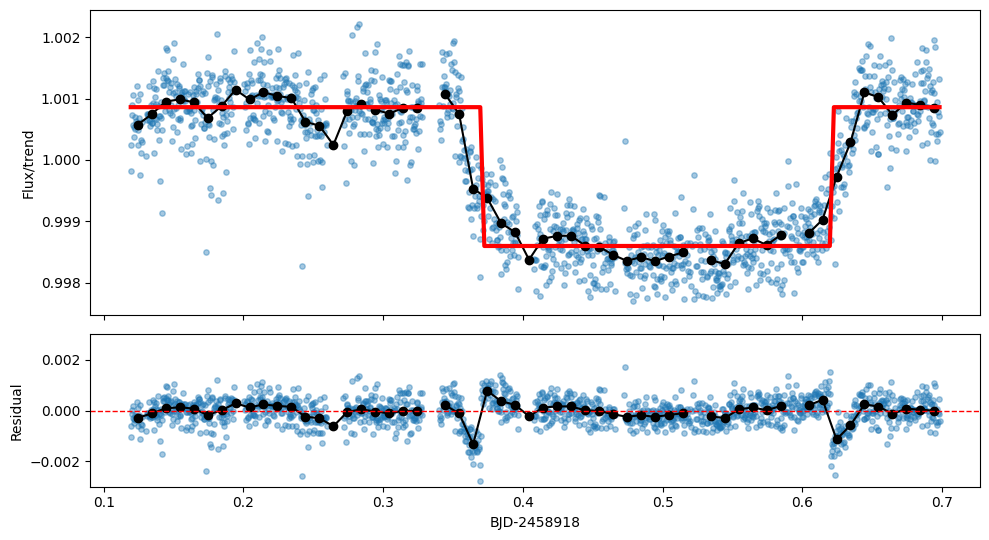

In [113]:
t_fit = np.linspace(list(BJD)[0],list(BJD)[-1],200)
flux_norm, flux_norm_err = get_norm_flux(fluxes_combinations[1], flux_combinations_error[1], sigma=2)
plotter(sampler,BJD,flux_norm)
plt.savefig("light_curve.png")

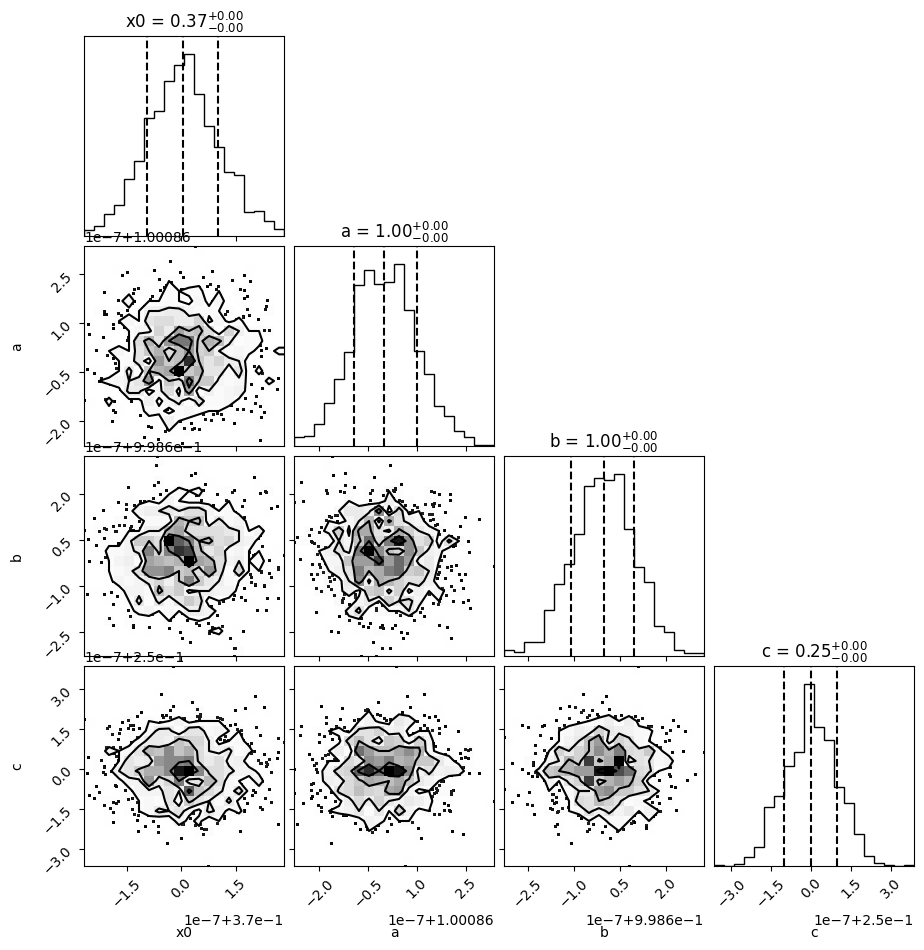

In [114]:
labels = ["x0","a","b",'c']
samples = sampler.flatchain
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig("corner_plot.png")

In [115]:
parameters = ["x0","a","b","c"]
dict = {"x0":[],"a":[],"b":[],"c":[]}
for i,param in enumerate(dict.keys()):
    q_16, q_50, q_84 = corner.quantile(samples[:,i], [0.16, 0.5, 0.84])
    uncertainty_down, uncertainty_up = q_50-q_16, q_84-q_50
    dict[param] += [uncertainty_down, q_50, uncertainty_up]
    
df_mcmc = pd.DataFrame(dict)
df_mcmc

x0             a             b             c
0  9.847880e-08  9.385620e-08  1.058096e-07  1.023994e-07
1  3.700000e-01  1.000860e+00  9.986000e-01  2.500000e-01
2  9.813936e-08  1.015120e-07  9.828790e-08  9.756111e-08